# Generic Example Test for Differential Evolution Based Symbolic Regression (DESR) for Equation: y = sin(X) + 2 + e #

## Import Relevant Packages ##

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys;sys.path.append("../")
from desr import Generator, Equation, TrainingData, \
                 Optimizer, LaplaceApproximation, DifferentialEvolution

## Initialize Data (This can be done using either numpy/torch for data) ##

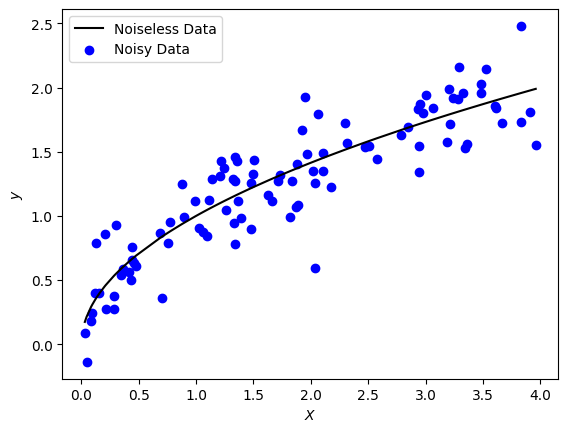

In [2]:
X = np.random.uniform(0, 4, 100)
X.sort()
y = np.sqrt(X) 
std_dev = y.std()/2
y_noisy = y + np.random.normal(loc=0, scale=std_dev, size=X.shape)
training_data = TrainingData(x=X, y=y_noisy)

plt.plot(X, y, label="Noiseless Data", color="k")
plt.scatter(X, y_noisy, label="Noisy Data", color="b")
plt.xlabel(r"$X$")
plt.ylabel(r"$y$")
plt.legend()


## Initialize Optimizer (Used for deterministic optimization), Generator and Operators ##

In [3]:

optimizer = Optimizer(training_data)
generator = Generator(genotype_size=16, X_dim=training_data.x.shape[1])
operators = ["add", "sub", "mult", "sqrt", "pow", "log", "sin", "pow"]
generator.add_operators(operators)


## Initialize Bayesian Fitness (Laplace Approximation for Marginal Likelihood) and Differential Evolution Instance

In [4]:
laplace_approximation = LaplaceApproximation(optimizer)
differential_evolution = DifferentialEvolution(chains=20, generator=generator,
                            bayesian_fitness=laplace_approximation)

equation = Equation(expression="sin(log(X_0)) + X_0 - 1.5")
print(f"Target Fitness: {laplace_approximation(equation)}")

/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:292: RuntimeWarning: overflow encountered in square
  return np.exp(-x**2/2.0) / _norm_pdf_C
/Users/nolanstrauss/codes/DESR/examples/../desr/bayesian_fitness/laplace_approximation.py:38: RuntimeWarning: divide by zero encountered in log
  np.log(norm(loc=0, scale=std).pdf(R.detach().numpy()))


Target Fitness: 285.8869435485633


## Generate Samples Using Differential Evolution ##

In [5]:
differential_evolution.sample(iterations=100, return_states=False)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/nolanstrauss/codes/DESR/examples/../desr/differential_evolution.py:62: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(-proposed_state.fitness+current_state.fitness)
  2%|▏         | 2/100 [00:01<01:32,  1.06it/s]/Users/nolanstrauss/codes/DESR/examples/../desr/differential_evolution.py:62: RuntimeWarning: invalid value encountered in scalar add
  ratio = np.exp(-proposed_state.fitness+current_state.fitness)
100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


## Print All Unique Accepted States and Fitness (From high to low, note: fitness=inf may occur due to nan comparisons in initial stages) ##

In [6]:
N = 5 #This restricts the print to the N best fit equations found
for i, state in enumerate(differential_evolution.unique_accepted_states[-N:]):
    print(f"Model_{i} Expression: {str(state)}")
    print(f"Model_{i} Fitness: {str(state.fitness)}\n")

Model_0 Expression: (X_0)^(I_0)
Model_0 Fitness: 36.079833490859116

Model_1 Expression: (((X_0)^(I_1))^(I_0))^(I_0)
Model_1 Fitness: 36.079833490859116

Model_2 Expression: ((X_0 + ((I_2 * I_2) * (C_0)^(I_1))))^(I_0)
Model_2 Fitness: 36.079833490859116

Model_3 Expression: ((X_0 + log((C_0)^(I_0))))^(I_0)
Model_3 Fitness: 36.03942303975241

Model_4 Expression: ((X_0 + (I_2 * (C_0)^(I_1))))^(I_0)
Model_4 Fitness: 36.0394230275431



## Print Unique Final Accepted States and Fitness (From high to low) ##

In [7]:
for i, state in enumerate(differential_evolution.unique_states):
    print(f"Model_{i} Expression: {str(state)}")
    print(f"Model_{i} Fitness: {str(state.fitness)}\n")

Model_0 Expression: (X_0)^(0.5)
Model_0 Fitness: 36.079833490859116



## Plot N Unique Accepted States ##

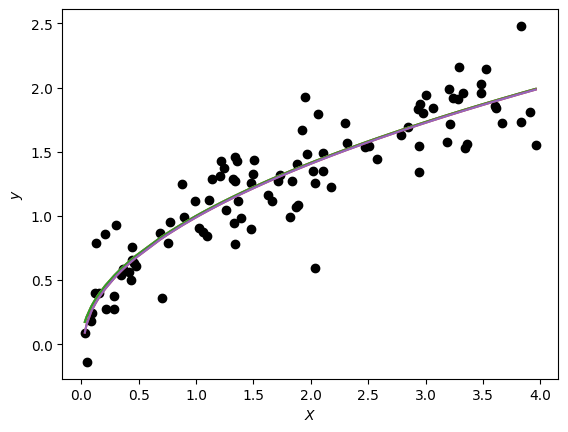

In [9]:
fig, axs = plt.subplots()
axs.scatter(training_data.x.detach().numpy(), training_data.y.detach().numpy(), label="Noisy Data", color="k")

for i, state in enumerate(differential_evolution.unique_accepted_states[-N:]):
    axs.plot(training_data.x.detach().numpy().squeeze(), state.evaluate_equation(training_data.x).detach().numpy().squeeze(), label=f"Model_{i}")
axs.set_xlabel(r"$X$")
axs.set_ylabel(r"$y$")
if N < 5: #Ignore if legend size will be too large.
    axs.legend()